### <center>ICCS 261 Term Project</center>
# <center>Meteorite Landings: Patterns and Predictions</center>
#### <center>Submitted by Parit Vacharaskunee, ID 6580209<center>

-----------

#### **Introduction to the Research Question**

To be done...

***Research Question***:
- Can meteorites be classified by its weight, location it landed, and whether it was found or fell?
- 

**Resource: https://data.nasa.gov/Space-Science/Meteorite-Landings/gh4g-9sfh/about_data**

#### **Purpose and Objectives**

***Purpose***: Gain insights into the patterns and characteristics that might help distinguish the types of meteorites. Find patterns or trends that could be useful towards the study of Meteorology.

***Objectives***: The main objective is to determine if the characteristics of meteorites (mass, geolocation, and its found status) can be used to distinguish the different types of meteorites. This will be done by making classification models and determine the possibility by analyzing the respective scores and performance of the models.

----

#### **Data Cleaning and Preparation**

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [44]:
df = pd.read_csv('./Meteorite_Landings_20240521.csv')
df

,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775, 6.08333)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.18333, 10.23333)"
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.21667, -113.0)"
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.88333, -99.9)"
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.16667, -64.95)"
...,...,...,...,...,...,...,...,...,...,...
45711,Zillah 002,31356,Valid,Eucrite,172.0,Found,1990.0,29.03700,17.01850,"(29.037, 17.0185)"
45712,Zinder,30409,Valid,"Pallasite, ungrouped",46.0,Found,1999.0,13.78333,8.96667,"(13.78333, 8.96667)"
45713,Zlin,30410,Valid,H4,3.3,Found,1939.0,49.25000,17.66667,"(49.25, 17.66667)"
45714,Zubkovsky,31357,Valid,L6,2167.0,Found,2003.0,49.78917,41.50460,"(49.78917, 41.5046)"


In [45]:
df = df.drop(['id', 'nametype', 'GeoLocation'], axis = 1) # columns are insignificant is not needed
df.isna().sum()

name           0
recclass       0
mass (g)     131
fall           0
year         291
reclat      7315
reclong     7315
dtype: int64

In [46]:
# filling locations and year with forward fill
df[['reclat', 'reclong', 'year']] = df[['reclat', 'reclong', 'year']].fillna(method = 'ffill')

In [47]:
# using median due to a skewed distribution
med = df['mass (g)'].median() 
df['mass (g)'] = df['mass (g)'].fillna(value = med)

# final drops
df = df.dropna()

In [48]:
df.isna().sum()

name        0
recclass    0
mass (g)    0
fall        0
year        0
reclat      0
reclong     0
dtype: int64

In [49]:
len(df['recclass'].unique())

466

There are [3 main types](https://en.wikipedia.org/wiki/Meteorite_classification#Rubin_classification) of meteorites: iron, stony-iron, and stony meteorites. Each of these 3 are also further classified into other names, as seen in the recclass column in the dataset. Since there are 462 unique classifications, I will regroup these names into 1 of 3 main meteorite types:

Stony:
- Carbonaceous chondrites: CI; CM; CR; CO; CV; CK; CH; Ungrouped Carbonaceous chondrite
- Ordinary chondrites: H; L; LL; HH
- Rumuruti chondrites: R
- Kakangari chondrites: K
- Enstatite chondrites: EH; EL; Ungrouped enstatite chondrites
- IAB/IIICD silicate chondrites
- Ungrouped chondrites
- Primitive achondrites: Acapulcoites; Lodranites; Winonaites; Ungrouped primitive achondrites
- Differentiated meteorites:
- Asteroidal achondrites: Eucrites; Diogenites; Howardites; Angrites; Aubrites; Ureilites; Brachinites
- Martian meteorites: Shergottites; Nakhlites; Chassigny; ALH 84001
- Lunar meteorites: Mare basalts; Impact breccias

Stony irons: 
- Pallasites
- Mesosiderites
- Ungrouped stony irons

Irons:
- Magmatic irons groups: IC; IIAB; IIC; IID; IIF; IIIAB; IIIE; IIIF; IVA; IVB
- Nonmagmatic irons groups: IAB/IIICD; IIE
- Ungrouped irons

In [50]:
uniques = pd.DataFrame(df['recclass'].unique())
# retreive classes with keyword 'iron
iron = uniques[uniques[0].str.contains('Iron')]
iron = pd.concat([iron, uniques[uniques[0].str.contains('iron')]])

# retreive classes with keywords regarding stony irons
stony_iron = uniques[uniques[0].str.contains('Pallasite')]
stony_iron = pd.concat([stony_iron, uniques[uniques[0].str.contains('Mesosiderite')]])

# dropping out irons and stony irons from the main dataset
stone = uniques.drop(iron.index).drop(stony_iron.index)

In [51]:
# renaming the names in recclass. WARNING: if cell is run twice, do a run-all.
df['recclass'] = df['recclass'].replace(iron.values, 'Iron')
df['recclass'] = df['recclass'].replace(stony_iron.values, 'Stony Iron')
df['recclass'] = df['recclass'].replace(stone.values, 'Stone')

In [52]:
df['recclass'].unique() # checking the unique names

array(['Stone', 'Iron', 'Stony Iron'], dtype=object)

----

#### **Data Exploration and Statistical Analysis: Proposal Reflection**


 Stone Median: 30.6 g
 Iron Media n: 8770.0 g
 Stony Iron Median: 492.31 g


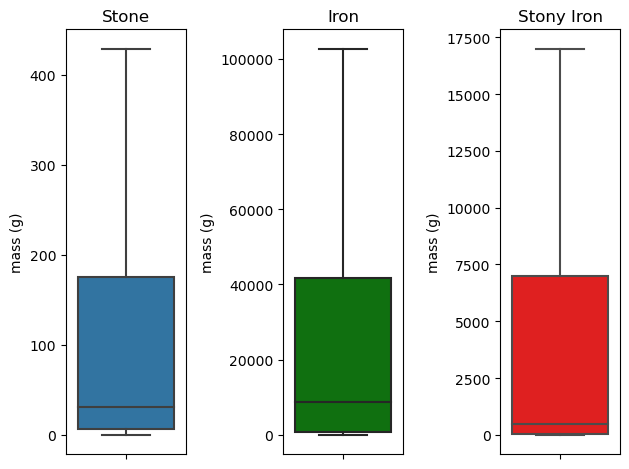

In [53]:
fig, axes = plt.subplots(1, 3, tight_layout = True)
sns.boxplot(ax = axes[0], data = df[df['recclass'] == 'Stone'], y = 'mass (g)', showfliers = False)
sns.boxplot(ax = axes[1], data = df[df['recclass'] == 'Iron'], y = 'mass (g)', showfliers = False, color = 'g')
sns.boxplot(ax = axes[2], data = df[df['recclass'] == 'Stony Iron'], y = 'mass (g)', showfliers = False, color = 'r')

axes[0].set_title('Stone')
axes[1].set_title('Iron')
axes[2].set_title('Stony Iron')

st_med = df[df['recclass'] == 'Stone']['mass (g)'].median()
ir_med = df[df['recclass'] == 'Iron']['mass (g)'].median()
si_med = df[df['recclass'] == 'Stony Iron']['mass (g)'].median()

print(f'\n Stone Median: {st_med} g\n Iron Media n: {ir_med} g\n Stony Iron Median: {si_med} g')

Here we can see the average mass (disregarding outliers) of each types of meteorites. It can be seen that iron meteorites are the heaviest, followed by stony iron, and then stone. This could be a potential use towards making a classification model of each type of meteorites.

----

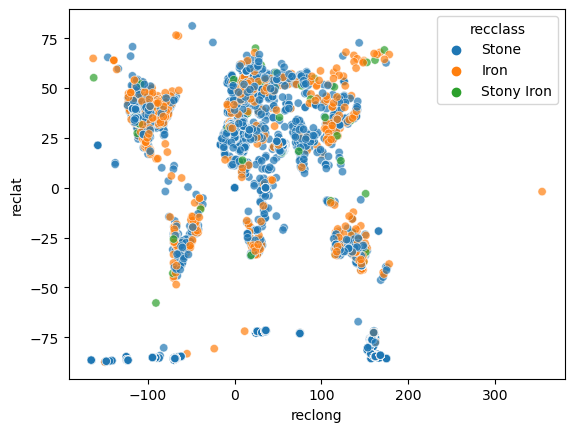

In [54]:
sns.scatterplot(x = df['reclong'], y = df['reclat'], alpha = 0.7, hue = df['recclass'])
plt.show()

The locations of the meteorites do not show any significant pattern, but could prove useful as a parameter in the model as well.

----

See the number of fallen meteors each year. I am not including meteors that was found as the year is not the year that the meteor fell, which can effect the rate of fallen meteors on specific years.

In [55]:
fallen_meteors = df[df['fall'] == 'Fell']
fallen_meteors

,name,recclass,mass (g),fall,year,reclat,reclong
0,Aachen,Stone,21.0,Fell,1880.0,50.77500,6.08333
1,Aarhus,Stone,720.0,Fell,1951.0,56.18333,10.23333
2,Abee,Stone,107000.0,Fell,1952.0,54.21667,-113.00000
3,Acapulco,Stone,1914.0,Fell,1976.0,16.88333,-99.90000
4,Achiras,Stone,780.0,Fell,1902.0,-33.16667,-64.95000
...,...,...,...,...,...,...,...
1106,Zhuanghe,Stone,2900.0,Fell,1976.0,39.66667,122.98333
1107,Zmenj,Stone,246.0,Fell,1858.0,51.83333,26.83333
1108,Zomba,Stone,7500.0,Fell,1899.0,-15.18333,35.28333
1109,Zsadany,Stone,552.0,Fell,1875.0,46.93333,21.50000


In [56]:
years = pd.DataFrame(fallen_meteors['year'].value_counts())
years

,year
1933.0,17
1949.0,13
1976.0,12
1950.0,12
1938.0,11
...,...
1632.0,1
1849.0,1
2013.0,1
920.0,1


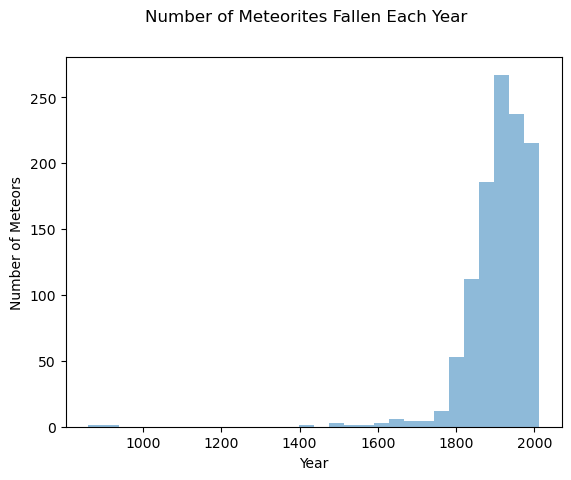

In [57]:
fig, ax = plt.subplots()
fig.suptitle("Number of Meteorites Fallen Each Year")
ax.hist(fallen_meteors['year'], bins = 30, alpha = 0.5)
ax.set(xlabel = 'Year', ylabel = "Number of Meteors")
plt.show()

----

#### **Models**

**Random Forest Model #1: Classification of Meteorites**

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Get Independent Variables

In [59]:
fell = pd.get_dummies(df['fall']).drop(columns = 'Found')

x = pd.DataFrame(df['mass (g)'])
x['reclat'] = df['reclat']
x['reclong'] = df['reclong']
x['fell'] = fell
x['year'] = df['year']
x

,mass (g),reclat,reclong,fell,year
0,21.0,50.77500,6.08333,1,1880.0
1,720.0,56.18333,10.23333,1,1951.0
2,107000.0,54.21667,-113.00000,1,1952.0
3,1914.0,16.88333,-99.90000,1,1976.0
4,780.0,-33.16667,-64.95000,1,1902.0
...,...,...,...,...,...
45711,172.0,29.03700,17.01850,0,1990.0
45712,46.0,13.78333,8.96667,0,1999.0
45713,3.3,49.25000,17.66667,0,1939.0
45714,2167.0,49.78917,41.50460,0,2003.0


Get y Variables for Training

In [60]:
y = df.recclass
y

0             Stone
1             Stone
2             Stone
3             Stone
4             Stone
            ...    
45711         Stone
45712    Stony Iron
45713         Stone
45714         Stone
45715         Stone
Name: recclass, Length: 45716, dtype: object

In [61]:
# split train-test
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.3, random_state = 10)

In [62]:
# fitting random forest model with tree size of 100
rf_model = RandomForestClassifier(n_estimators=100) #TODO: change weight to balanced
_ = rf_model.fit(xtrain, ytrain)

Confusion Matrix for Visualization

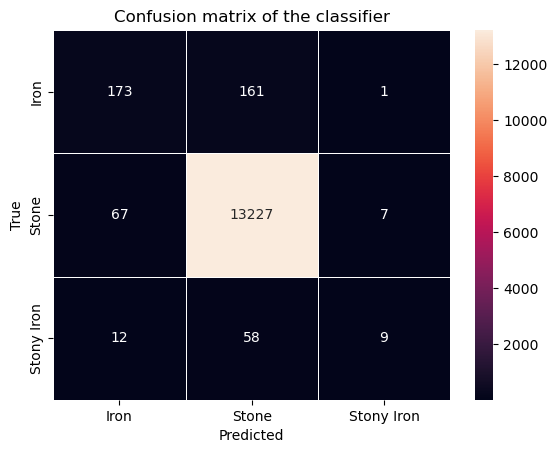

In [63]:
cm = confusion_matrix(ytest, rf_model.predict(xtest))

labels = ['Iron', 'Stone', 'Stony Iron']
sns.heatmap(cm, annot = True, fmt = 'd', linewidths = 0.5, xticklabels = labels, yticklabels = labels)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Evaluating Test Scores

In [64]:
yhat_test = rf_model.predict(xtest)
print(f'Accuracy: {accuracy_score(ytest, yhat_test)}')
precision_recall_fscore_support(ytest, yhat_test)

Accuracy: 0.9776886620488516


(array([0.68650794, 0.98371263, 0.52941176]),
 array([0.51641791, 0.99443651, 0.11392405]),
 array([0.58943782, 0.9890455 , 0.1875    ]),
 array([  335, 13301,    79], dtype=int64))

The model is able to distinguish stone from the other, but fails to do so for iron and stony iron. It could also be possible that since there is so much more stone meteorites, it outweighs the other two types which causes a bad yield on the other two. Now let's try a model without stones.

**Random Forest Model #2: Classifying Stony Iron and Iron Meteorites**

In [65]:
df2 = pd.concat([df[df['recclass'] == 'Stony Iron'], df[df['recclass'] == 'Iron']])

Get Independent Variables

In [66]:
fell2 = pd.get_dummies(df2['fall']).drop(columns = 'Found')

x2 = pd.DataFrame(df2['mass (g)'])
x2['reclat'] = df2['reclat']
x2['reclong'] = df2['reclong']
x2['fell'] = fell2
x2['year'] = df2['year']

Get y Variable for Testing

In [67]:
y2 = df2.recclass

In [167]:
acc = 0
n = 0   
while acc < 0.897:
    # split train-test
    xtrain2, xtest2, ytrain2, ytest2 = train_test_split(x2, y2, test_size = 0.3, random_state = n)

    # fit model
    rf_model2 = RandomForestClassifier(n_estimators=100)
    _ = rf_model2.fit(xtrain2, ytrain2)
    
    acc = accuracy_score(ytest2, rf_model2.predict(xtest2))
    n += 1
    print(n)

print("-> ", n - 1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169


KeyboardInterrupt: 

Confusion Matrix for Evaluation

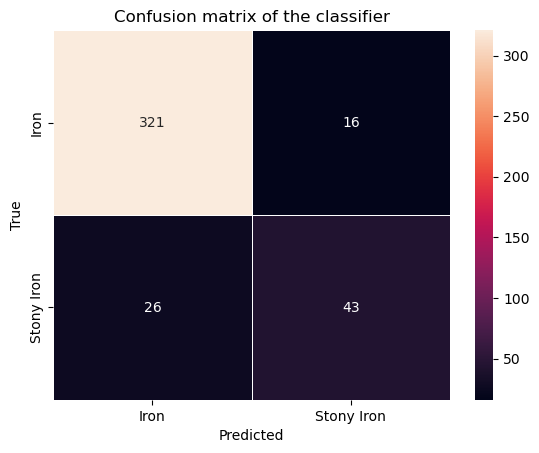

In [69]:
cm2 = confusion_matrix(ytest2, rf_model2.predict(xtest2))

labels2 = ['Iron', 'Stony Iron']
sns.heatmap(cm2, annot = True, fmt = 'd', linewidths = 0.5, xticklabels = labels2, yticklabels = labels2)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Evaluating Scores

In [70]:
yhat_test2 = rf_model2.predict(xtest2)
print(f'Accuracy: {accuracy_score(ytest2, yhat_test2)}')
precision_recall_fscore_support(ytest2, yhat_test2) #TODO: recheck scores for class0 and class1

Accuracy: 0.896551724137931


(array([0.92507205, 0.72881356]),
 array([0.95252226, 0.62318841]),
 array([0.93859649, 0.671875  ]),
 array([337,  69], dtype=int64))

According to the model above, by removing stone meteorites, the model was able to perform much better on distinguish the 2 types. However, I believe that this is not a quality model that can be used to help classify the different types of meteorites. ***Add more description and interpretation of the results above***

----

For additional information, I will be creating a model between iron and stone meteorites as well as the model tend to perform well to distinguish these two types.

In [71]:
df3 = pd.concat([df[df['recclass'] == 'Stone'], df[df['recclass'] == 'Iron']])

In [72]:
fell3 = pd.get_dummies(df3['fall']).drop(columns = 'Found')

x3 = pd.DataFrame(df3['mass (g)'])
x3['reclat'] = df3['reclat']
x3['reclong'] = df3['reclong']
x3['fell'] = fell3
x3['year'] = df3['year']

In [73]:
y3 = df3.recclass

In [163]:
# split train-test
xtrain3, xtest3, ytrain3, ytest3 = train_test_split(x3, y3, test_size = 0.3, random_state = 100)

# fit model
rf_model3 = RandomForestClassifier(n_estimators=100, class_weight = "balanced") 
_ = rf_model3.fit(xtrain3, ytrain3)

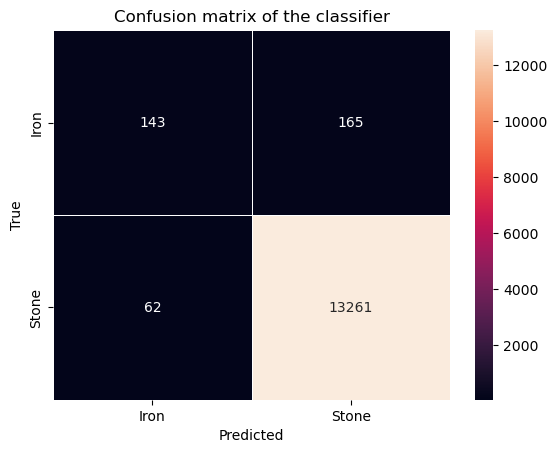

In [164]:
cm3 = confusion_matrix(ytest3, rf_model3.predict(xtest3))

labels3 = ['Iron', 'Stone']
sns.heatmap(cm3, annot = True, fmt = 'd', linewidths = 0.5, xticklabels = labels3, yticklabels = labels3)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [165]:
yhat_test3 = rf_model3.predict(xtest3)
print(f'Accuracy: {accuracy_score(ytest3, yhat_test3)}')
precision_recall_fscore_support(ytest3, yhat_test3)

Accuracy: 0.9833467830680067


(array([0.69756098, 0.98771041]),
 array([0.46428571, 0.99534639]),
 array([0.55750487, 0.9915137 ]),
 array([  308, 13323], dtype=int64))

Like above, the model is only able to fit the stone meteorites really well due to the number of data values. For this reason, I decided to add in the weight parameter on the next model to see the performance.

----
Now let's try adding the weight to each of the classes to see if it would help (since stone meteorites contains such a large amount of entries).

In [77]:
# finding total observations
iron_obs = len(df[df['recclass'] == 'Iron'])
stone_obs = len(df[df['recclass'] == 'Stone'])
stonyiron_obs = len(df[df['recclass'] == 'Stony Iron'])

total_obs = len(df['recclass'])

# calculate weight -> total obs / (num of class * total obs) 
iron_weight = total_obs / (3 * iron_obs)
stone_weight = total_obs / (3 * stone_obs)
stonyiron_weight = total_obs / (3 * stonyiron_obs)

weights = {'Stony Iron': stonyiron_weight, 'Stone': stone_weight, 'Iron': iron_weight}

In [78]:
# fitting random forest model with tree size of 100, and with a balanced weight
rf_model4 = RandomForestClassifier(n_estimators=100, class_weight = weights)
_ = rf_model4.fit(xtrain, ytrain)

In [79]:
accuracy_score(ytest, rf_model4.predict(xtest))

0.977032446226759

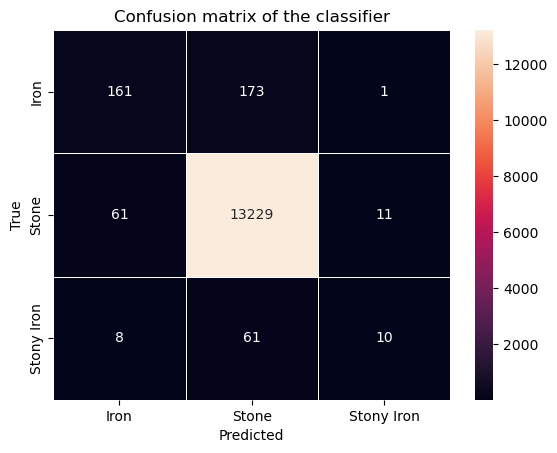

In [101]:
cm4 = confusion_matrix(ytest, rf_model4.predict(xtest))

labels = ['Iron', 'Stone', 'Stony Iron']
sns.heatmap(cm4, annot = True, fmt = 'd', linewidths = 0.5, xticklabels = labels, yticklabels = labels)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Judging by the accuracy and confusion matrix, there is barely any difference in the model's performance.

----
Lastly, let's try to achieve a better balanced model using XGBoost

In [115]:
import xgboost as xgb

In [128]:
y5 = df.recclass
y5 = y5.replace('Stone', 0).replace('Iron', 1).replace('Stony Iron', 2)

In [129]:
xtrain5, xtest5, ytrain5, ytest5 = train_test_split(x, y5, test_size = 0.3, random_state = 5)

In [150]:
xgb_weights = np.ones(len(ytrain5))
xgb_weights[ytrain5 == 0] = stone_weight
xgb_weights[ytrain5 == 1] = iron_weight
xgb_weights[ytrain5 == 2] = stonyiron_weight

In [130]:
params = {
    'booster': 'gbtree',
    'objective': 'multi:softprob',
    'num_class': len(set(y)),
    'max_depth': 10,
    'eta': 1, 
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'num_parallel_tree': 100,
    'tree_method': 'approx'
}

In [141]:
xgb_md = xgb.XGBRFClassifier(
    n_estimators=100,    
    max_depth=100,          
    learning_rate=1,     
    subsample=0.8,         
    colsample_bytree=0.8   
)

In [151]:
xgb_md.fit(xtrain5, ytrain5, sample_weight = xgb_weights)

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=0.8, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=1, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=100, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=100, n_jobs=None,
                num_parallel_tree=None, objective='multi:softprob',
                random_state=None, ...)

In [152]:
yhat_test5 = xgb_md.predict(xtest5)
print(f'Accuracy: {accuracy_score(ytest5, yhat_test5)}')
precision_recall_fscore_support(ytest5, yhat_test5)

Accuracy: 0.9640539555231499


(array([0.987829  , 0.48801743, 0.10909091]),
 array([0.97624417, 0.67878788, 0.14457831]),
 array([0.98200242, 0.56780735, 0.12435233]),
 array([13302,   330,    83], dtype=int64))

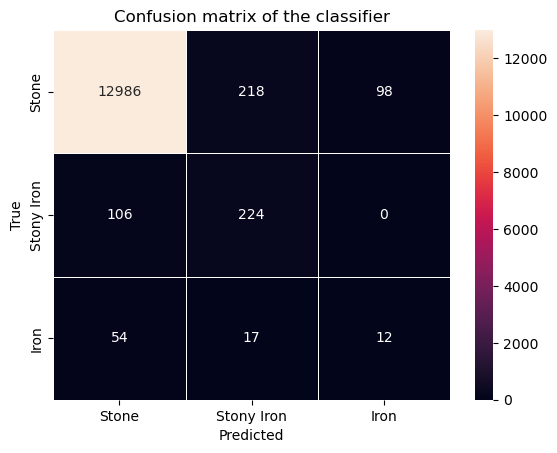

In [153]:
cm5 = confusion_matrix(ytest5, yhat_test5)

labels = ['Stone', 'Stony Iron', 'Iron']
sns.heatmap(cm5, annot = True, fmt = 'd', linewidths = 0.5, xticklabels = labels, yticklabels = labels)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### **Interpretation and Analysis**

Random Forest Classifier -> label data (stone, iron, iron-stone) https://en.wikipedia.org/wiki/Meteorite_classification#Rubin_classification, then use lat, long, mass

Clustering Models
